# Citation Prediction EDA

A structured analysis of arXiv paper metadata and citation counts, covering:
1. **Data Loading & Cleaning**
2. **Preprocessing & Feature Engineering**
3. **Exploratory Data Analysis** — including the discovery of age-adjusted popularity thresholds
4. **Baseline Modeling** — XGBoost regression for citation count prediction

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

DATA_PATH = "../data/eda_papers.csv"
RANDOM_STATE = 42

## 1. Data Loading

In [2]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} papers.")
display(df.head())

Loaded 102215 papers.


,arxiv_id,title,abstract,authors,primary_category,all_categories,published_at,citation_count
0,2511.01118,Generative Machine Learning Models for the Dec...,Charge carrier dynamics critically affect the ...,Li Raymond|Salim Flora|Wang Sijin|Wright Brendan,cond-mat.mtrl-sci,cond-mat.mtrl-sci|cs.LG,2025-11-02T23:32:05+00:00,0
1,2511.01113,S2Doc -- Spatial-Semantic Document Format,Documents are a common way to store and share ...,Sebastian Kempf|Frank Puppe,cs.DL,cs.DL|cs.CL,2025-11-02T23:06:03+00:00,0
2,2511.01109,Anatomically Constrained Transformers for Echo...,Video transformers have recently demonstrated ...,Alexander Thorley|Agis Chartsias|Jordan Strom|...,cs.CV,cs.CV,2025-11-02T22:52:30+00:00,0
3,2511.01107,SLAP: Shortcut Learning for Abstract Planning,Long-horizon decision-making with sparse rewar...,Y. Isabel Liu|Bowen Li|Benjamin Eysenbach|Tom ...,cs.RO,cs.RO|cs.LG,2025-11-02T22:48:31+00:00,1
4,2511.01104,HarnessLLM: Automatic Testing Harness Generati...,Existing LLM-based automatic test generation m...,Yujian Liu|Jiabao Ji|Yang Zhang|Wenbo Guo|Tomm...,cs.SE,cs.SE|cs.CL,2025-11-02T22:41:15+00:00,0


## 2. Preprocessing & Feature Engineering

We extract:
- **Age**: Days since publication, binned into 7-day (weekly) groups
- **Content length**: Title and abstract character counts
- **Team size**: Number of authors
- **Category groups**: Top 20 primary categories, rest grouped as 'Other'

In [3]:
# Datetime & age
df['published_at'] = pd.to_datetime(df['published_at'])
df['age_days'] = (pd.Timestamp.now(tz='UTC') - df['published_at']).dt.days

# Filter very new papers (< 30 days) — citations haven't stabilized
df = df[df['age_days'] > 30].copy()

# Text features
df['title_len'] = df['title'].fillna('').apply(len)
df['abstract_len'] = df['abstract'].fillna('').apply(len)

# Author count
df['num_authors'] = df['authors'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)

# Category grouping
if 'primary_category' in df.columns:
    top_cats = df['primary_category'].value_counts().nlargest(20).index
    df['category_group'] = df['primary_category'].apply(lambda x: x if x in top_cats else 'Other')

# Age binning (weekly) — daily bins are too noisy, weekly gives stable aggregates
df['age_bin'] = (df['age_days'] // 7) * 7
df['age_bin'] = pd.to_numeric(df['age_bin'], errors='coerce')
df['citation_count'] = pd.to_numeric(df['citation_count'], errors='coerce').fillna(0)
df = df.dropna(subset=['age_bin']).copy()
df['age_bin'] = df['age_bin'].astype(int)

print(f"After preprocessing: {len(df)} papers")
display(df[['title_len', 'abstract_len', 'num_authors', 'age_days', 'age_bin', 'citation_count']].describe())

After preprocessing: 102046 papers


,title_len,abstract_len,num_authors,age_days,age_bin,citation_count
count,102046.000000,102046.000000,102046.000000,102046.000000,102046.000000,102046.000000
mean,82.859642,1320.224075,5.411697,204.588744,201.673000,2.619838
std,23.150041,308.000534,12.554638,97.773771,97.804685,18.969382
min,5.000000,51.000000,1.000000,31.000000,28.000000,0.000000
25%,68.000000,1110.000000,3.000000,122.000000,119.000000,0.000000
50%,82.000000,1320.000000,5.000000,203.000000,203.000000,0.000000
75%,97.000000,1538.000000,6.000000,282.000000,280.000000,2.000000
max,240.000000,3488.000000,3435.000000,375.000000,371.000000,3176.000000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Citation Distribution

Citations follow a heavy long-tail distribution — most papers receive very few citations,
while a small fraction receive hundreds or thousands.

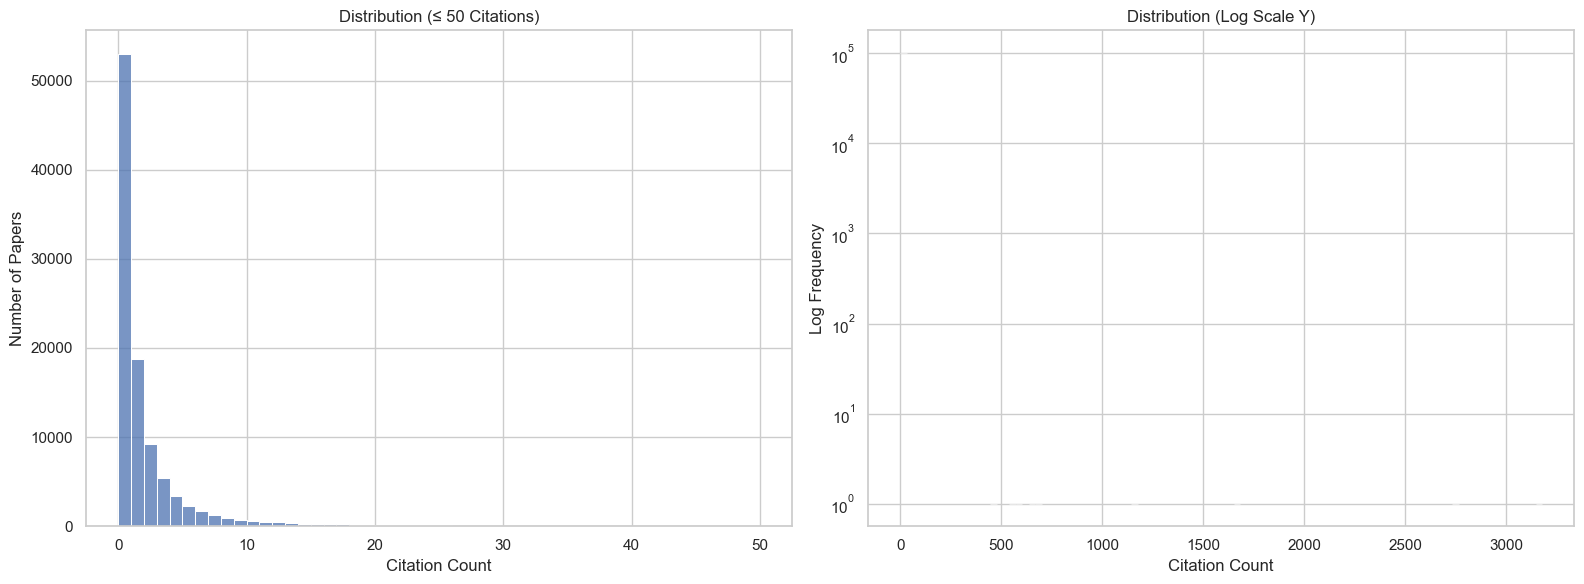

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Zoomed view for low counts
sns.histplot(data=df[df['citation_count'] <= 50], x='citation_count', bins=50, ax=axes[0], kde=False)
axes[0].set_title('Distribution (≤ 50 Citations)')
axes[0].set_xlabel('Citation Count')
axes[0].set_ylabel('Number of Papers')

# Log scale for full range
sns.histplot(data=df, x='citation_count', bins=100, ax=axes[1], log_scale=(False, True))
axes[1].set_title('Distribution (Log Scale Y)')
axes[1].set_xlabel('Citation Count')
axes[1].set_ylabel('Log Frequency')

plt.tight_layout()
plt.show()

### 3.2 Feature Relationships

How do key metadata features relate to citation counts?

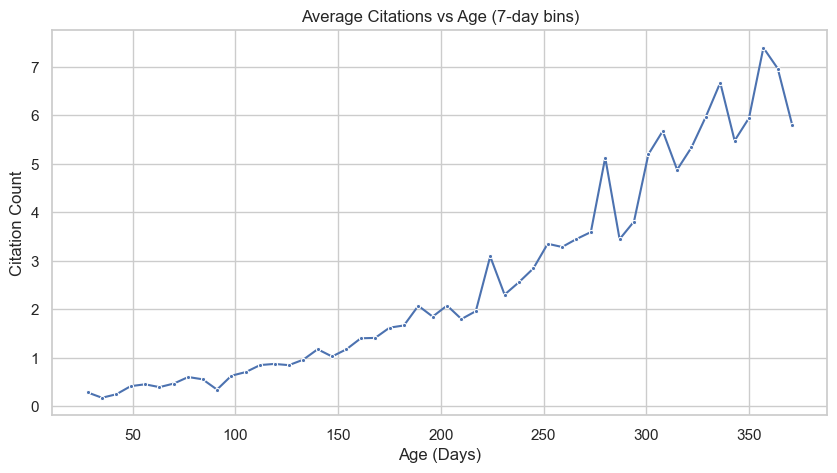

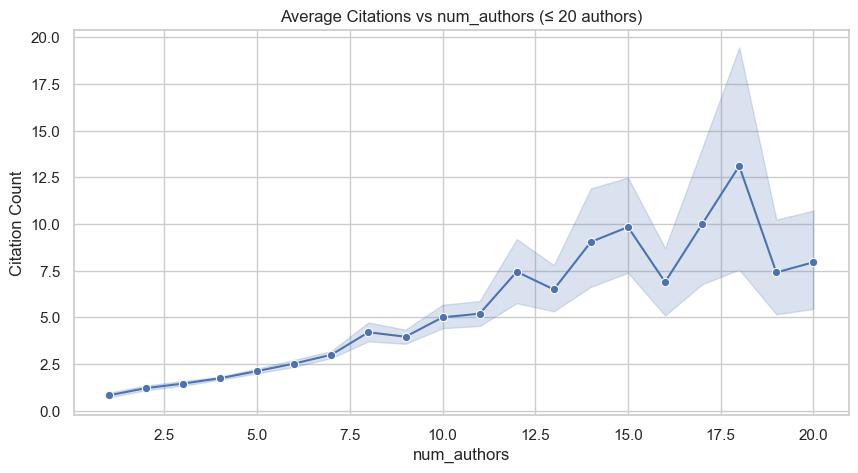

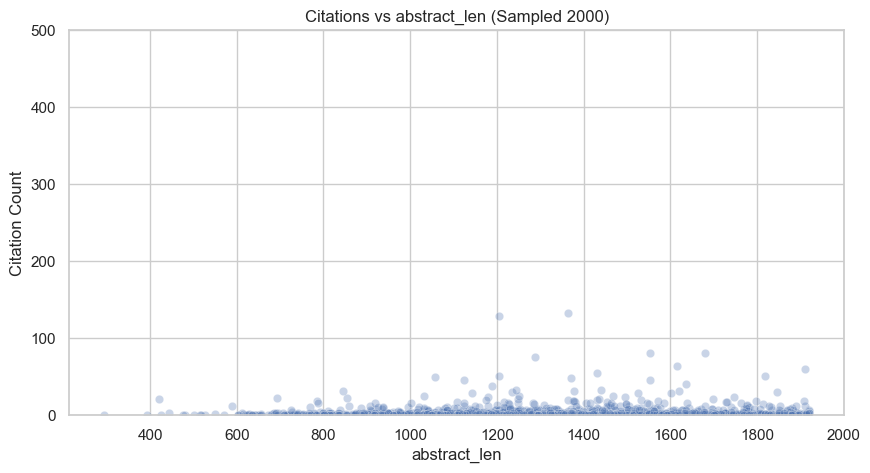

In [5]:
features = ['age_days', 'num_authors', 'abstract_len']

for feat in features:
    plt.figure(figsize=(10, 5))

    if feat == 'age_days':
        age_trend = df.groupby('age_bin')['citation_count'].mean().reset_index()
        sns.lineplot(data=age_trend, x='age_bin', y='citation_count', marker='o', markersize=3)
        plt.title('Average Citations vs Age (7-day bins)')
        plt.xlabel('Age (Days)')
    elif feat == 'num_authors':
        temp_df = df[df['num_authors'] <= 20]
        sns.lineplot(data=temp_df, x='num_authors', y='citation_count', marker='o')
        plt.title(f'Average Citations vs {feat} (≤ 20 authors)')
    else:
        sns.scatterplot(data=df.sample(2000, random_state=RANDOM_STATE), x=feat, y='citation_count', alpha=0.3)
        plt.title(f'Citations vs {feat} (Sampled 2000)')
        plt.ylim(0, 500)

    plt.ylabel('Citation Count')
    plt.show()

### 3.3 Average Citations by Category

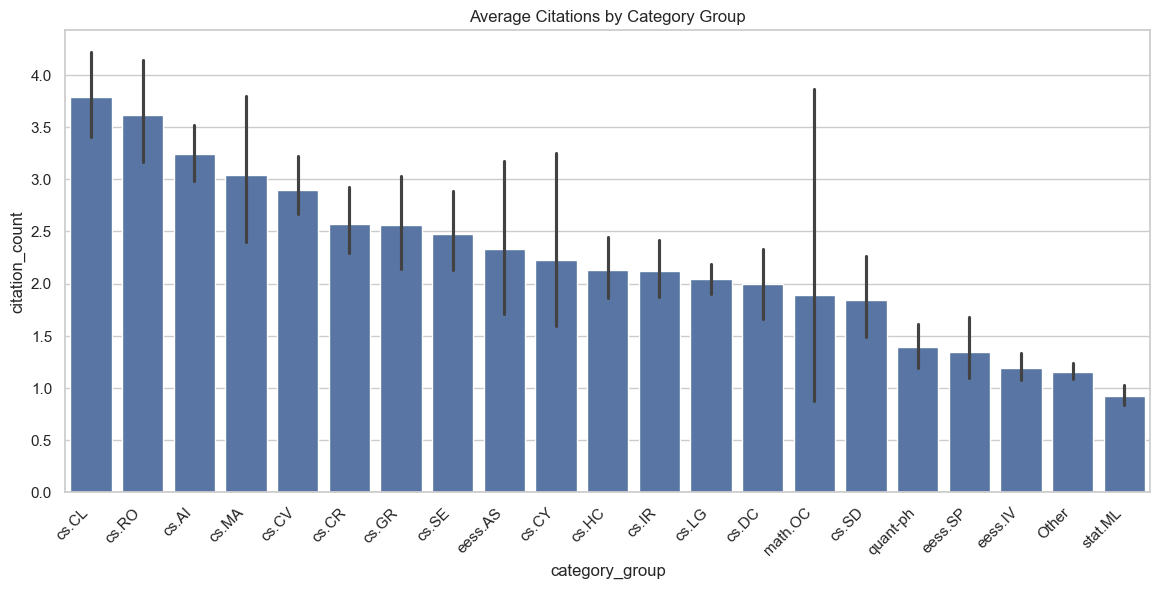

In [6]:
plt.figure(figsize=(14, 6))
order = df.groupby('category_group')['citation_count'].mean().sort_values(ascending=False).index
sns.barplot(data=df, x='category_group', y='citation_count', order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Average Citations by Category Group')
plt.show()

### 3.4 The Problem: Classifying Paper Impact

We want to classify papers as **low**, **mid**, or **high** impact based on citation count.
But citation counts grow with paper age — a 1-year-old paper with 10 citations is average,
while a 1-month-old paper with 10 citations is exceptional.

**We need age-adjusted thresholds.** Let's discover the right approach step by step.

#### Step 0 — Why weekly bins?

Daily `age_days` bins have too few papers per bin, making citation statistics noisy.
Grouping into **7-day (weekly) bins** gives enough papers per bin for stable averages.

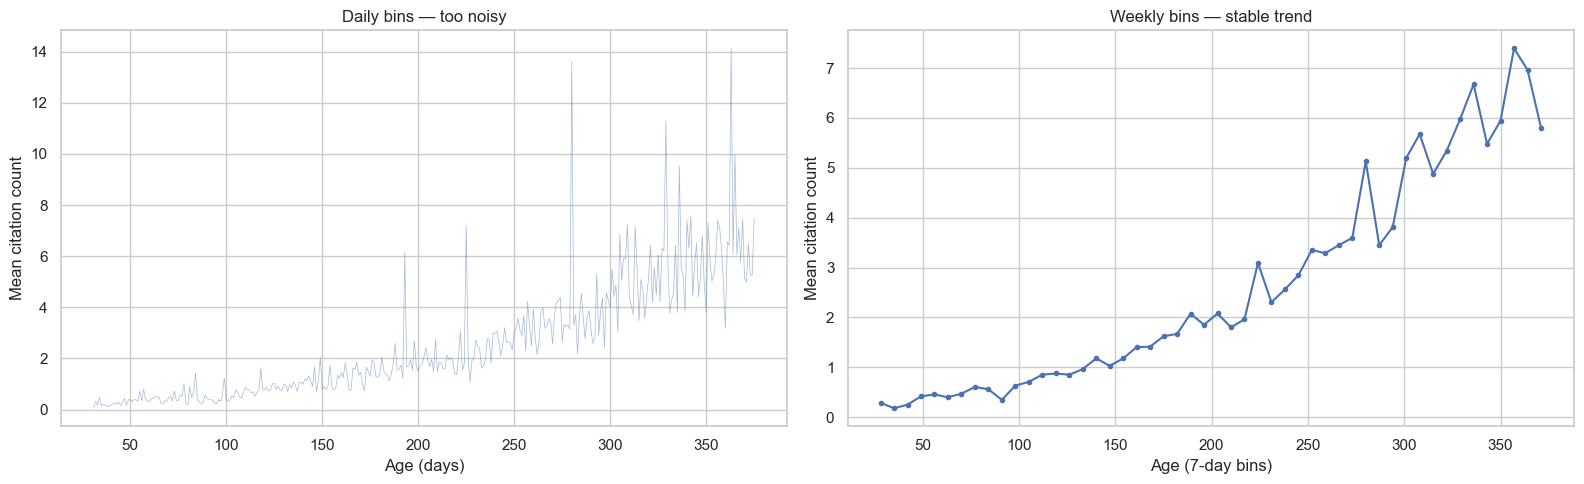

In [7]:
# Compare daily vs weekly stability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Daily bins (noisy)
daily_avg = df.groupby('age_days')['citation_count'].mean()
ax1.plot(daily_avg.index, daily_avg.values, alpha=0.5, linewidth=0.5)
ax1.set_title('Daily bins — too noisy')
ax1.set_xlabel('Age (days)')
ax1.set_ylabel('Mean citation count')

# Weekly bins (stable)
weekly_avg = df.groupby('age_bin')['citation_count'].mean()
ax2.plot(weekly_avg.index, weekly_avg.values, marker='o', markersize=3)
ax2.set_title('Weekly bins — stable trend')
ax2.set_xlabel('Age (7-day bins)')
ax2.set_ylabel('Mean citation count')

plt.tight_layout()
plt.show()

#### Step 1 — Citations are strongly correlated with age

Older papers naturally accumulate more citations. Any classification must account for this.

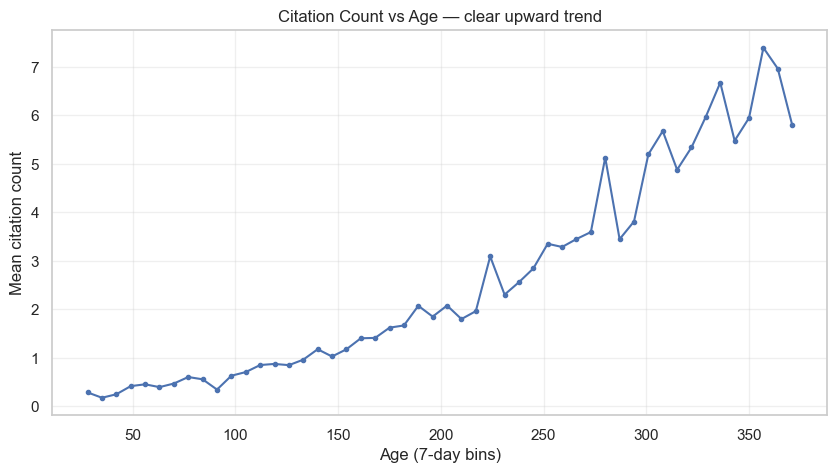

Correlation (age_bin vs citation_count): 0.104


In [8]:
weekly_avg = df.groupby('age_bin')['citation_count'].mean()

plt.figure(figsize=(10, 5))
plt.plot(weekly_avg.index, weekly_avg.values, marker='o', markersize=3)
plt.xlabel('Age (7-day bins)')
plt.ylabel('Mean citation count')
plt.title('Citation Count vs Age — clear upward trend')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation (age_bin vs citation_count): {df['age_bin'].corr(df['citation_count']):.3f}")

#### Step 2 — Naive approach: fixed citation bins (fails!)

If we use fixed thresholds (e.g., 0-5 = low, 5-20 = mid, 20+ = high),
the class proportions **shift dramatically** with age — almost all young papers are "low"
and almost all old papers are "mid/high". This makes the classification age-dependent, not quality-dependent.

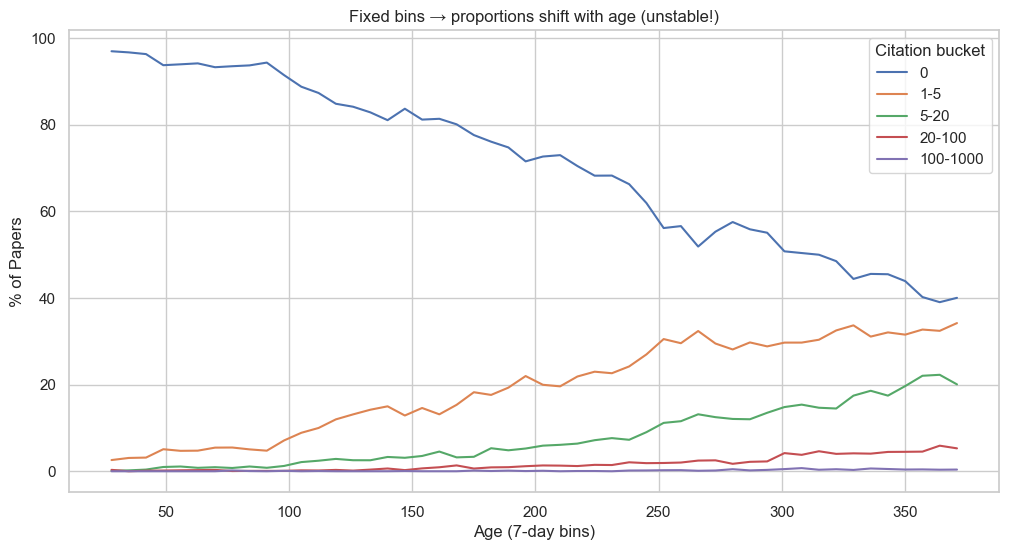

In [9]:
# Fixed-bin approach
bins = [0, 1, 5, 20, 100, 1000, df['citation_count'].max()]
labels = ['0', '1-5', '5-20', '20-100', '100-1000', '1000+']
df['naive_bucket'] = pd.cut(df['citation_count'], bins=bins, labels=labels, include_lowest=True)

# Show how proportions change with age
pivot_naive = (
    df.groupby(['age_bin', 'naive_bucket']).size()
    .unstack(fill_value=0)
)
pivot_naive_pct = pivot_naive.div(pivot_naive.sum(axis=1), axis=0) * 100

# Plot (exclude 1000+ for readability)
plot_cols = ['0', '1-5', '5-20', '20-100', '100-1000']
pivot_naive_pct[plot_cols].plot(figsize=(12, 6))
plt.xlabel('Age (7-day bins)')
plt.ylabel('% of Papers')
plt.title('Fixed bins → proportions shift with age (unstable!)')
plt.legend(title='Citation bucket')
plt.show()

df.drop(columns=['naive_bucket'], inplace=True)

#### Step 3 — Linear thresholds: better, but imperfect

Instead of fixed bins, we can set thresholds that grow **linearly** with age:
- `mid_threshold = c1 × age_bin`
- `high_threshold = c2 × age_bin`

This accounts for the age-citation relationship, but the proportions still drift
because citation growth isn't perfectly linear.

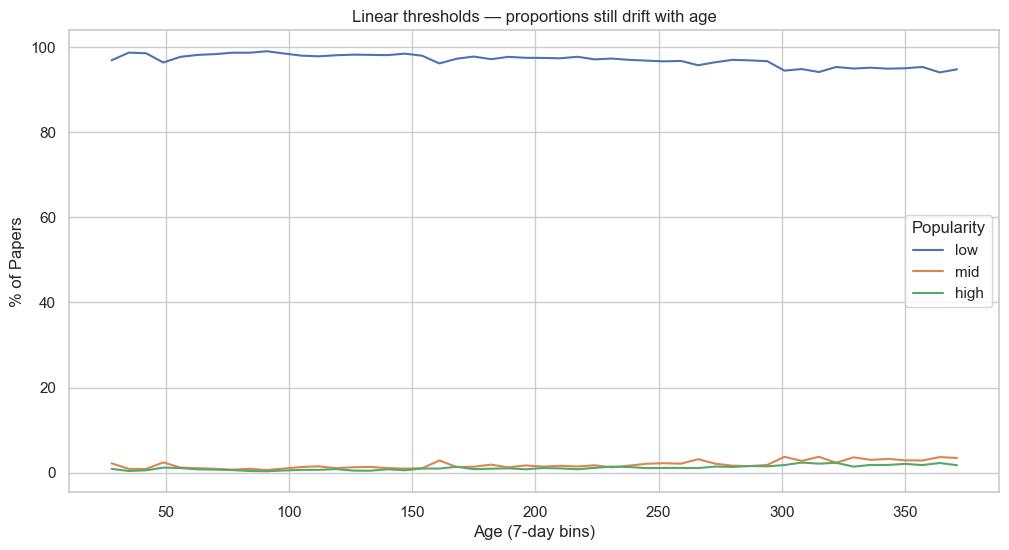

In [10]:
# Linear thresholds
c1_lin, c2_lin = 0.06, 0.12

mid_t_lin = df['age_bin'] * c1_lin
high_t_lin = df['age_bin'] * c2_lin

conditions_lin = [
    df['citation_count'] < mid_t_lin,
    (df['citation_count'] >= mid_t_lin) & (df['citation_count'] < high_t_lin),
    df['citation_count'] >= high_t_lin,
]
df['linear_bucket'] = np.select(conditions_lin, ['low', 'mid', 'high'], default='low')

# Check stability
pivot_lin = df.groupby(['age_bin', 'linear_bucket']).size().unstack(fill_value=0)
pivot_lin_pct = pivot_lin.div(pivot_lin.sum(axis=1), axis=0) * 100
pivot_lin_pct = pivot_lin_pct[['low', 'mid', 'high']]

pivot_lin_pct.plot(figsize=(12, 6))
plt.xlabel('Age (7-day bins)')
plt.ylabel('% of Papers')
plt.title('Linear thresholds — proportions still drift with age')
plt.legend(title='Popularity')
plt.show()

df.drop(columns=['linear_bucket'], inplace=True)

#### Step 4 — Exponential (power-law) thresholds: stable classification ✓

Citation growth follows a slight power law. Using `c × age_bin ^ degree` with `degree = 1.08`
gives **near-constant class proportions** across all age groups. The thresholds:

```python
degree = 1.08
c1 = 0.019  # mid threshold
c2 = 0.035  # high threshold
```

These constants were tuned to produce stable proportions and a meaningful
split (majority low, small mid, smaller high).

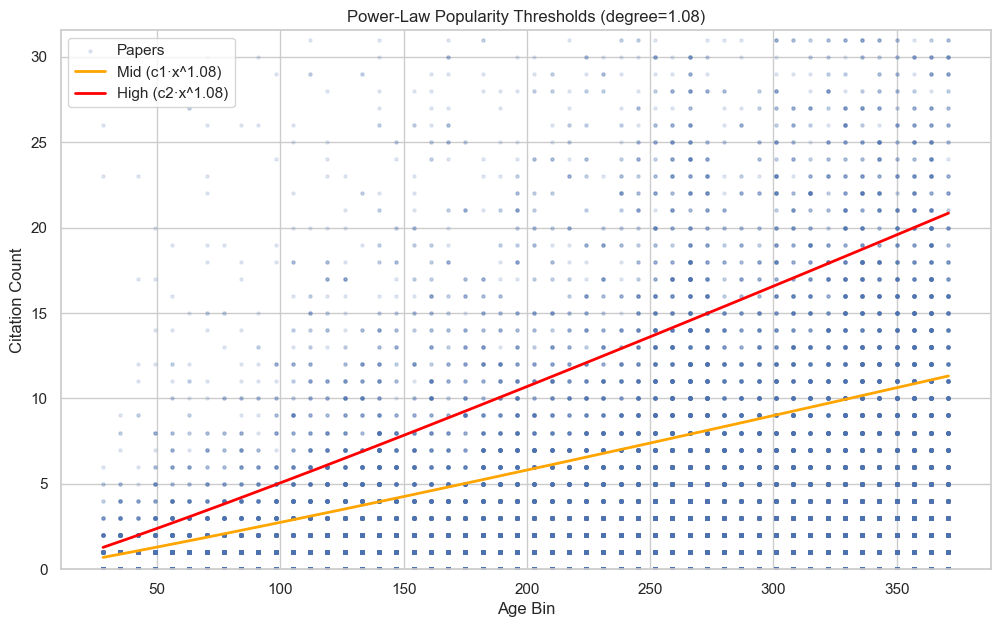

popularity_bucket
low     94246
mid      4323
high     3477
Name: count, dtype: int64


In [11]:
# Exponential (power-law) thresholds
degree = 1.08
c1 = 0.019   # mid threshold
c2 = 0.035   # high threshold

mid_threshold = c1 * (df['age_bin'] ** degree)
high_threshold = c2 * (df['age_bin'] ** degree)

conditions = [
    df['citation_count'] < mid_threshold,
    (df['citation_count'] >= mid_threshold) & (df['citation_count'] < high_threshold),
    df['citation_count'] >= high_threshold,
]
df['popularity_bucket'] = np.select(conditions, ['low', 'mid', 'high'], default='low')

# ── Visual validation: scatter + threshold curves ──
plt.figure(figsize=(12, 7))
plt.scatter(df['age_bin'], df['citation_count'], alpha=0.15, s=5, label='Papers')

x_range = np.linspace(df['age_bin'].min(), df['age_bin'].max(), 200)
plt.plot(x_range, c1 * (x_range ** degree), color='orange', linewidth=2, label=f'Mid (c1·x^{degree})')
plt.plot(x_range, c2 * (x_range ** degree), color='red', linewidth=2, label=f'High (c2·x^{degree})')

plt.title(f'Power-Law Popularity Thresholds (degree={degree})')
plt.xlabel('Age Bin')
plt.ylabel('Citation Count')
plt.ylim(0, df['citation_count'].quantile(0.99))
plt.legend()
plt.show()

print(df['popularity_bucket'].value_counts())

/Users/jeffersonqiu/Desktop/projects/bcg_learning/ai_paper_summarizer/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


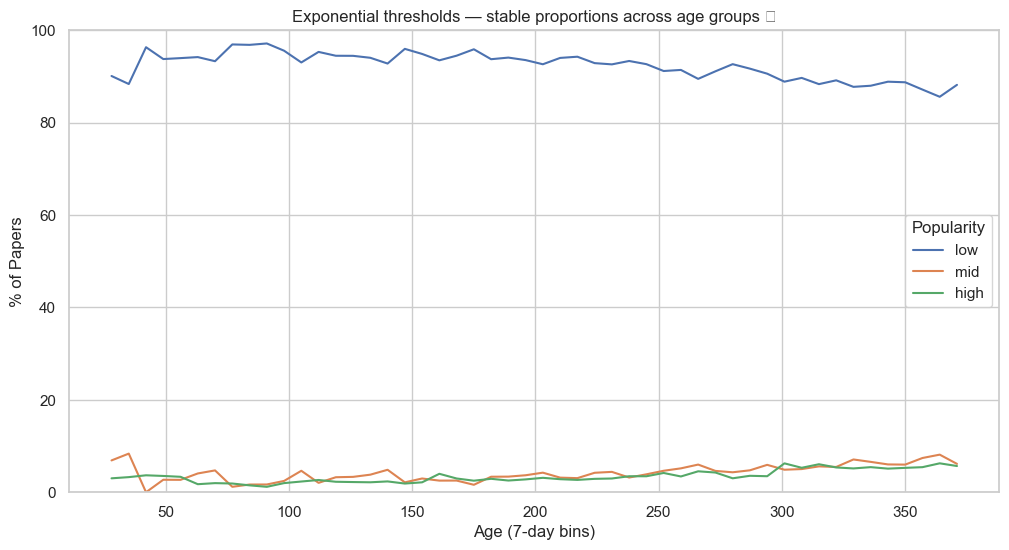

In [12]:
# ── Stability check: proportions should be flat across age groups ──
pivot_exp = df.groupby(['age_bin', 'popularity_bucket']).size().unstack(fill_value=0)
pivot_exp_pct = pivot_exp.div(pivot_exp.sum(axis=1), axis=0) * 100
pivot_exp_pct = pivot_exp_pct[['low', 'mid', 'high']]

pivot_exp_pct.plot(figsize=(12, 6))
plt.xlabel('Age (7-day bins)')
plt.ylabel('% of Papers')
plt.title('Exponential thresholds — stable proportions across age groups ✓')
plt.legend(title='Popularity')
plt.ylim(0, 100)
plt.show()

#### Step 5 — Filter: age ≥ 200 days for reliable signal

Very young papers (< 200 days) haven't had enough time to accumulate citations.
Their "low" classification is often just because they're new, not because they're uninteresting.
For model training, we restrict to papers **≥ 200 days old**.

In [13]:
# Show why age >= 200 matters
age_groups = [
    ('< 100 days', df[df['age_days'] < 100]),
    ('100-200 days', df[(df['age_days'] >= 100) & (df['age_days'] < 200)]),
    ('>= 200 days', df[df['age_days'] >= 200]),
]

print(f"{'Age group':<16} {'Papers':>8} {'Low':>8} {'Mid':>8} {'High':>8} {'High %':>8}")
print('-' * 60)
for label, subset in age_groups:
    total = len(subset)
    vc = subset['popularity_bucket'].value_counts()
    low = vc.get('low', 0)
    mid = vc.get('mid', 0)
    high = vc.get('high', 0)
    print(f"{label:<16} {total:>8,} {low:>8,} {mid:>8,} {high:>8,} {high/total:>8.1%}")

paper_df = df[df['age_days'] >= 200].copy()
print(f"\nFiltered dataset for modeling: {len(paper_df):,} papers")
print(paper_df['popularity_bucket'].value_counts())

Age group          Papers      Low      Mid     High   High %
------------------------------------------------------------
< 100 days         18,954   17,901      603      450     2.4%
100-200 days       30,903   29,146      999      758     2.5%
>= 200 days        52,189   47,199    2,721    2,269     4.3%

Filtered dataset for modeling: 52,189 papers
popularity_bucket
low     47199
mid      2721
high     2269
Name: count, dtype: int64


## 4. Baseline Modeling (XGBoost)

A preliminary XGBoost regressor to understand feature importance and get baseline error metrics.
Uses only the basic features extracted above.

In [14]:
# Features for baseline model
numeric_cols = ['age_days', 'num_authors', 'title_len', 'abstract_len']
cat_dummies = pd.get_dummies(paper_df['category_group'], prefix='cat')

X = pd.concat([paper_df[numeric_cols], cat_dummies], axis=1)
y = paper_df['citation_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
print('Training model...')
model.fit(X_train, y_train)

preds = np.maximum(model.predict(X_test), 0)  # citations can't be negative

metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
    'MAE': mean_absolute_error(y_test, preds),
    'R²': r2_score(y_test, preds),
}
print('\nBaseline Model Performance:')
for k, v in metrics.items():
    print(f'  {k}: {v:.4f}')

Training model...

Baseline Model Performance:
  RMSE: 42.9643
  MAE: 4.9002
  R²: -0.4791


<Figure size 1000x800 with 0 Axes>

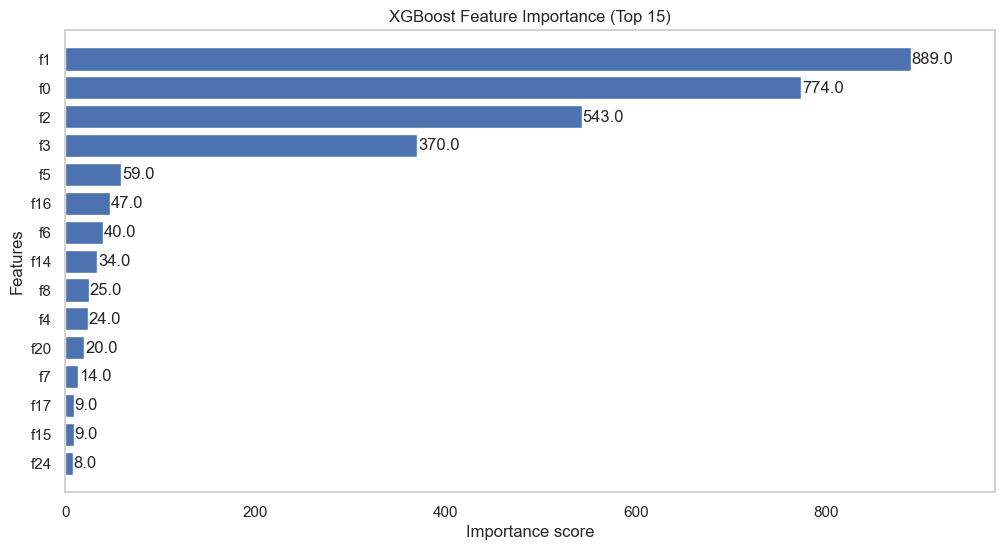

In [15]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, height=0.8, grid=False)
plt.title('XGBoost Feature Importance (Top 15)')
plt.show()